# CHAPTER 19: Convergence Analysis I: Stochastic Gradient Algorithms

### This code runs simulations for Examples 3 and 4 and generates figures 2 and 3 from Chapter 19: Convergence Analysis I: Stochastic Gradient Algorithms (vol I)
TEXT: A. H. Sayed, INFERENCE AND LEARNING FROM DATA, Cambridge University Press, 2022.

<div style="text-align: justify">
DISCLAIMER:  This computer code is  provided  "as is"   without  any  guarantees.
Practitioners  should  use it  at their own risk.  While  the  codes in  the text 
are useful for instructional purposes, they are not intended to serve as examples 
of full-blown or optimized designs. The author has made no attempt at optimizing 
the codes, perfecting them, or even checking them for absolute accuracy. In order 
to keep the codes at a level  that is  easy to follow by students, the author has 
often chosen to  sacrifice  performance or even programming elegance in  lieu  of 
simplicity. Students can use the computer codes to run variations of the examples 
shown in the text. 
</div>

The Jupyter notebook and python codes are developed by Semanur Avşar 

Required Libraries:

1. numpy
2. matplotlib
3. spicy

Required Functions:

1. generate_logistic
2. logistic_minimizer
3. sample_r

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [15]:
from generate_logistic import generate_logistic
from logistic_minimizer import logistic_minimizer
from sample_r import sample_r

## Example 19.5 (Simulating random reshuffling)

We compare the performance of the stochastic gradient algorithm ($19.1$) with constant step size under both uniform sampling and random reshuffling for the instantaneous gradient approximation  ($19.4a$). The objective is to illustrate the superior steady-state performance under random reshuffling. According to result ($19.79b$), if we plot the steady-state deviation value $P(\mathbf{w}_{n}^k)- P(w^{\star})$, as $k\rightarrow\infty$,  versus the step size parameter $\mu$ in a log-log scale, the slope of the resulting line should be at least 2  since 

$$
\log_{10} \Bigl(\mathbb{E}[P(w_{n}^k)- P(w^{\star})]\Bigr) \leq 2\log_{10}(\mu), \quad k\rightarrow\infty \tag{19.83}
$$

In other words, if the step size is reduced by a factor of $10$ from $\mu$ to $\mu/10$, then the risk deviation should be reduced by at least a factor of $100$.  In comparison, under uniform sampling, we know from 
($19.18c$) that the risk deviation will be reduced by at least the same factor $10$. We illustrate this behavior by means of a simulation. Consider the $\ell_2-$regularized logistic empirical risk:

$$
P(w) = \rho\|w\|^2 + \frac{1}{N}\sum_{m=0}^{N-1} \ln\left(1+e^{-\gamma(m) h_m^\top w}\right),\quad w\in\mathbb{R}^{M} \tag{19.84}
$$

with $\rho=0.1$ and $M=10$. The step size parameter is varied between $10^{-4}$ and $10^{-3}$. The simulation generates $N=1000$ random pairs of data $\{\gamma(m),h_m\}$ according to a logistic model. First, a random parameter model $w^a\in \mathbb{R}^{10}$ is selected, and a random collection of feature vectors $\{h_m\}$ are generated, say, with zero-mean unit-variance Gaussian entries. Then, for each $h_m$, the label $\gamma(m)$ is set to either $+1$ or $-1$ according to the following construction:

$$
\gamma(m) = 
\begin{cases}
+1 & \text{if } \left(\frac{1}{1+e^{-h_m^\top w^a}}\right) \geq 0.5 \\
-1 & \text{otherwise}
\end{cases} \tag{19.85}
$$

A total of $K=2000$ epochs are run over the data. In one simulation, we evaluate the risk value $P(w_{-1}^k)$ at the beginning of each epoch and subsequently average these values over all epochs to approximate the average deviation

$$
\mathbb{E}[P(\mathbf{w}_{n}^k) - P(\mathbf{w}^{\star})] \approx \frac{1}{K}\sum_{k'=1}^{K} P(\mathbf{w}_{-1}^{k'}) - P(\mathbf{w}^{\star}) \tag{19.86}
$$

In a second simulation, we use the risk value $P(w_{-1}^K)$ at the last epoch as the approximation for $\mathbb{E}x P(\mathbf{w}_{-1}^k)$, i.e.,

$$
\mathbb{E}[P(\mathbf{w}_{-1}^k) - P(\mathbf{w}^{\star})] \approx P(\mathbf{w}_{-1}^K) - P(\mathbf{w}^{\star}) \tag{19.87}
$$

Both approximations lead to similar results. We plot the variation of the risk deviations in the logarithmic scale against $\log_{10}(\mu)$ in Fig. $19.2$. The plot shows the simulated values for these risk deviations against the step size parameter. The vertical and horizontal scales are logarithmic. The dotted lines are the fitted regression lines, which provide an estimate of the slope variations for the measurements. The slopes of the lines for uniform sampling and random reshuffling are found in this simulation to be  
$1.3268$ and $2.8512$, respectively. 

In [16]:
# l2-regularized logistic regression
# P(w) = rho\|w\|^2 + (1/N)sum_{n=0}^{N-1} ln(1+exp(-gamma(m) h_m' w))

rho = 0.1  # l2-regularization parameter
M = 10   # feature size
N = 1000 # number of data points
K = 2000 # number of epochs

print('wait....generating data')

# Generating data and checking it
zo = np.random.rand(M).reshape(-1,1) # underlying parameter model for logistic data
p, gamma_vec, H = generate_logistic(N,zo,0) # logistic model with zero offset
ws, Ps, thetas = logistic_minimizer(rho, gamma_vec, H,0) # learns ws only

w = np.random.randn(M).reshape(-1,1) # initial condition for weight under uniform sampling
wrr = w.copy()        # same for weight under random reshuffling

mu_max = 0.001
mu_min = 0.0001
Delta = (mu_max-mu_min)/10
mu_vec = np.arange(mu_min, mu_max+Delta, Delta) # step-sizes

J = max(mu_vec.shape)

risk = np.zeros((J,2))
risk2 = np.zeros((J,2))
risk_w = np.zeros((J,2))

for j in range(J):
    mu = mu_vec[j]  
    P = np.zeros(K).reshape(-1,1) # learning curve over epochs under uniform sampling
    Prr = np.zeros(K).reshape(-1,1) # learning curve over epochs under random reshuffling

    for k in range(K): # iterating over runs
        for m in range(N): # evaluating empirical risk function at START of each epoch
            h_m = H[:, m].reshape(-1,1) # feature vector
            gamma_m = gamma_vec[m] # label
            a = ( 1 + np.exp(-gamma_m * np.dot(h_m.T, w)) )[0,0]
            P[k] += np.log(a)

            arr = ( 1 + np.exp(-gamma_m * np.dot(h_m.T, wrr)) )[0,0]
            Prr[k] += np.log(arr)

        P[k] = (1 / N) * P[k] # uniform sampling
        P[k] += rho * np.linalg.norm(w, ord=2) ** 2 # risk value at start of epoch k

        Prr[k] = (1 / N) * Prr[k] #random reshuffling
        Prr[k] += rho * np.linalg.norm(wrr, ord=2) ** 2 # risk value at start of epoch k

        URR = np.random.permutation(N) # random permutation of the samples

        for n in range(N): # iterating over data in each epoch
            u = np.random.randint(N) # uniform sampling
            h_u = H[:, u].reshape(-1,1) # feature vector
            gamma_u = gamma_vec[u] # label
            a = np.exp(-gamma_u * np.dot(h_u.T, w))
            s = gamma_u * h_u * a / (1 + a) # gradient vector

            w = (1 - 2 * mu * rho) * w + mu * s # updated w (stochastic gradient implementation)

            u = URR[n] # random reshuffling
            h_u = H[:, u].reshape(-1,1) # feature vector
            gamma_u = gamma_vec[u] # label
            arr = np.exp(-gamma_u * np.dot(h_u.T, wrr))
            srr = gamma_u * h_u * arr / (1 + arr) # gradient vector

            wrr = (1 - 2 * mu * rho) * wrr + mu * srr  # updated w (stochastic random reshuffling implementation)

    risk[j, :] = np.array([P[K-1] - Ps, Prr[K-1] - Ps])[:,0,0] # using risk value at end of epoch as estimate
    risk2[j, :] = np.array([np.mean(P[K-1]) - Ps, np.mean(Prr[K-1]) - Ps])[:,0,0] # using average risk value over epochs as estimate
    risk_w[j, :] = np.array([np.linalg.norm(w - ws) ** 2, np.linalg.norm(wrr - ws) ** 2]) # not used"b

wait....generating data


rho
0.1
dimension of model
10
number of runs
2000
Slopes in the logxlog domain for risk values:
first slope should be about 1 and second should be at least 2
First slope: 0.9784839657651735
Second slope (last-value of risk): 3.324696281019556
Second slope (averaged risk): 3.324696281019556


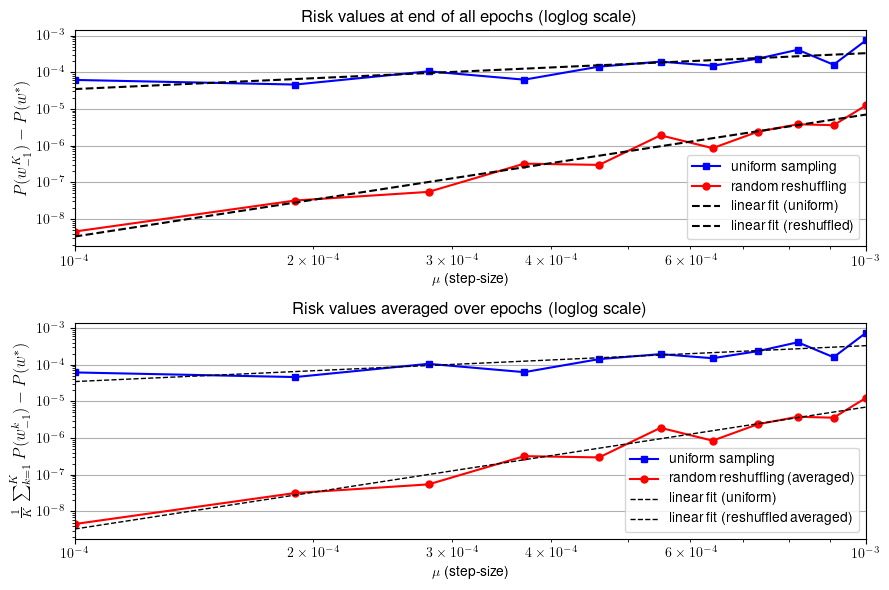

In [17]:
print('rho')
print(rho)

print('dimension of model')
print(M)

print('number of runs')
print(K)

# Fit linear regression
degree = 1
f0 = np.polyfit(np.log10(mu_vec), np.log10(risk[:, 0]), degree)
f0rr = np.polyfit(np.log10(mu_vec), np.log10(risk[:, 1]), degree)
f0rr2 = np.polyfit(np.log10(mu_vec), np.log10(risk2[:, 1]), degree)

p1 = f0[0]
p2 = f0[1]

p1rr = f0rr[0]
p2rr = f0rr[1]

p1rra = f0rr2[0]
p2rra = f0rr2[1]

f0w = np.polyfit(np.log10(mu_vec), np.log10(risk_w[:, 0]), degree)
f0wrr = np.polyfit(np.log10(mu_vec), np.log10(risk_w[:, 1]), degree)

p1w = f0w[0]
p2w = f0w[1]
p1wrr = f0wrr[0]
p2wrr = f0wrr[1]

print("Slopes in the logxlog domain for risk values:")
print('first slope should be about 1 and second should be at least 2')
print("First slope:", p1)
print("Second slope (last-value of risk):", p1rr)
print("Second slope (averaged risk):", p1rra)

line = np.zeros(J).reshape(-1,1)
linerr = np.zeros(J).reshape(-1,1)
linerra = np.zeros(J).reshape(-1,1)
linew = np.zeros(J).reshape(-1,1)
linewrr = np.zeros(J).reshape(-1,1)

for j in range(J):
    line[j] = np.log10(mu_vec[j]) * p1 + p2
    linerr[j] = np.log10(mu_vec[j]) * p1rr + p2rr
    linerra[j] = np.log10(mu_vec[j]) * p1rra + p2rra
    linew[j] = np.log10(mu_vec[j]) * p1w + p2w
    linewrr[j] = np.log10(mu_vec[j]) * p1wrr + p2wrr


# if mu decreases by 10-fold, risk values should decrease by at least 100-fold

#figure 2 (comparing random reshuffling with uniform sampling)

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})
                                              
plt.figure(figsize=(9,6))

# First subplot
plt.subplot(211)
plt.loglog(mu_vec, risk[:, 0], '-sb', markersize = 5, label='uniform sampling')
plt.loglog(mu_vec, risk[:, 1], '-or', markersize = 5, label='random reshuffling')
plt.semilogx(mu_vec, 10 ** line, '--k', linewidth = 1.5, label='linear fit (uniform)')
plt.semilogx(mu_vec, 10 ** linerr, '--k', linewidth = 1.5, label='linear fit (reshuffled)')
plt.xlabel('$\mu$ (step-size)')
plt.ylabel('$P(w_{-1}^K) - P(w^*)$', fontsize=12)
plt.title('Risk values at end of all epochs (loglog scale)')
plt.legend()
plt.xlim([10**(-4), 10**(-3)])
plt.grid()

# Second subplot
plt.subplot(212)
plt.loglog(mu_vec, risk[:, 0], '-sb', markersize = 5, label='uniform sampling')
plt.loglog(mu_vec, risk2[:, 1], '-or', markersize = 5, label='random reshuffling (averaged)')
plt.semilogx(mu_vec, 10 ** line, '--k', linewidth = 1, label='linear fit (uniform)')
plt.semilogx(mu_vec, 10 ** linerra, '--k', linewidth = 1, label='linear fit (reshuffled averaged)')
plt.xlabel('$\mu$ (step-size)')
plt.ylabel('$\\frac{1}{K}\\sum_{k=1}^K P(w_{-1}^k) - P(w^*)$', fontsize=12)
plt.title('Risk values averaged over epochs (loglog scale)')
plt.legend()
plt.xlim([10**(-4), 10**(-3)])
plt.grid()


plt.tight_layout()
plt.savefig('fig2-ch19.pdf', format='pdf')
plt.show()

**Figure 19.2** Random reshuffling has better risk deviation performance than uniform sampling. The plot shows the simulated values for these risk deviations against the step size parameter. The vertical and horizontal scales are logarithmic. The dotted lines are the fitted regression lines, which provide estimates for the slopes.

## Example 19.6 (Simulating importance sampling)

We illustrate the results by considering the regularized logistic regression problem: 

$$
P(w) = \rho\|w\|^2 + \frac{1}{N}\sum_{m=0}^{N-1} \ln\left(1+e^{-\gamma(m)h_m^\top w}\right) \tag{19.102}
$$

where $h_m\in  \mathbb{R}^{10}$ and $\gamma(m) \in\{\pm1\}$. In the simulation, we generate a random dataset $\{h_m,\gamma(m)\}$ with $N=500$ using the same logistic model from Example $19.5$. We set $\rho=0.01$, $\mu = 0.001$, and $\beta=0.25$. We also set the initial condition $\psi_{-1}=1000\,\mathbb{1}_{N}$. We run algorithm ($19.191$) over $K=200$ epochs and compute the risk values $P(w_{-1}^k)$ at the start of each epoch. This leads to a risk deviation curve $P(w_{-1}^k)-P(w^{\star})$ over the epoch index $k$. We repeat this simulation over $L=100$ trials and average the deviation curves. The results for uniform sampling and importance sampling are shown in Fig. $19.3$.

In [18]:
# l2-regularized logistic regression
# P(w) = rho\|w\|^2 + (1/N)sum_{n=0}^{N-1} ln(1+exp(-gamma(m) h_m' w))

M = 10  # feature size
N = 500 # number of data points
K = 200 # number of epochs

mu = 0.001
beta = 0.25
rho = 0.01

print('wait....generating data')

# Generating data and checking it
zo = np.random.rand(M).reshape(-1,1) # underlying parameter model for logistic data
p, gamma_vec, H = generate_logistic(N,zo,0) # logistic model with zero offset
ws, Ps, thetas = logistic_minimizer(rho, gamma_vec, H,0) # learns ws only
w = np.random.randn(M).reshape(-1,1) # initial condition for weight under uniform sampling
wis = w.copy()        # same for weight under importance sampling

Pmean = np.zeros(K)
Pismean = np.zeros(K)

experiments = 100 # averaged over 100 experiments

for ell in range(experiments):
    if ell % 10 == 0:
        print(ell)
    psi = 1000 * np.ones(N)
    tau = np.sum(psi)
    r = np.ones(N) / N

    P = np.zeros(K)  # Learning curve over epochs under uniform sampling
    Pis = np.zeros(K)  # Learning curve over epochs under random reshuffling

    for k in range(K):  # Iterating over runs
        for m in range(N):
            
            # Evaluating empirical risk function at START of each epoch 
            # (in the MATLAB Code this has a seperate for loop but I merged it with the other for loop to decrease run time)
            
            h_m = H[:, m]
            gamma_m = gamma_vec[m]

            a = 1 + np.exp(-gamma_m * np.dot(h_m, w))
            P[k] += np.log(a)

            ais = 1 + np.exp(-gamma_m * np.dot(h_m, wis))
            Pis[k] += np.log(ais)

            # Iterating over data in each epoch
            u = np.random.randint(N)  # Uniform sampling
            h_u = H[:, u]
            gamma_u = gamma_vec[u]

            a = np.exp(-gamma_u * np.dot(h_u, w))
            s = ( gamma_u * h_u * a / (1 + a) ).reshape(-1,1)  # Gradient vector
            w = (1 - 2 * mu * rho) * w + mu * s  # Updated w (stochastic gradient implementation)

            u = sample_r(r)  # Importance sampling
            pr = r[u]
            h_u = H[:, u]
            gamma_u = gamma_vec[u]

            ais = np.exp(-gamma_u * np.dot(h_u, wis))
            sis = ( gamma_u * h_u * ais / (1 + ais) ).reshape(-1,1)  # Gradient vector
            mu_norm = mu / (N * pr)  # Normalized step-size
            wis = (1 - 2 * mu_norm * rho) * wis + mu_norm * sis  # Updated w (importance sampling implementation)

            psi[u] = beta * psi[u] + (1 - beta) * np.linalg.norm(sis)  # Update one entry of vector psi
            tau = np.sum(psi)
            r = psi / tau
            
        P[k] = (1 / N) * P[k]  # Uniform sampling
        P[k] += rho * np.linalg.norm(w, 2)**2  # Risk value at the start of epoch k

        Pis[k] = (1 / N) * Pis[k]  # Random reshuffling
        Pis[k] += rho * np.linalg.norm(wis, 2)**2  # Risk value at the start of epoch k

    Pmean += P
    Pismean += Pis

Pmean /= experiments
Pismean /= experiments

wait....generating data
0
10
20
30
40
50
60
70
80
90


rho beta mu
0.01 , 0.25 , 0.001
dimension of model
10
number of runs
200


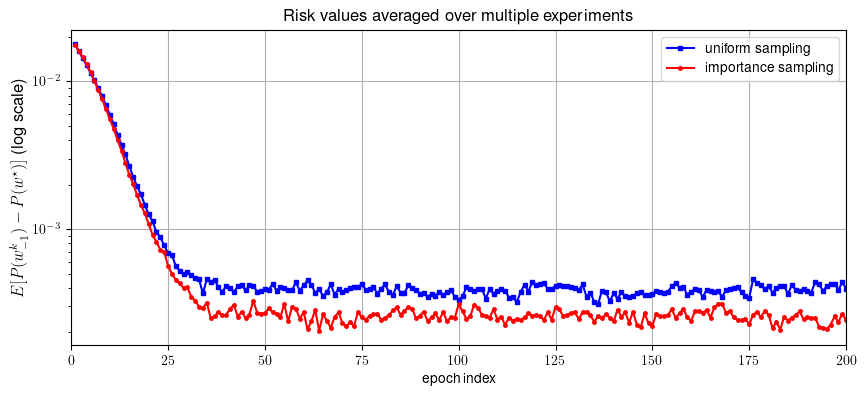

In [19]:
print('rho beta mu')
print(rho, ',', beta, ',', mu)

print('dimension of model')
print(M)

print('number of runs')
print(K)

#figure 3 (importance sampling)
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
})

plt.figure(figsize=(10,9))
plt.subplot(211)
plt.semilogy(np.arange(1, K + 1), (Pmean - Ps).reshape(-1), '-sb', markersize=2.5, label='uniform sampling')
plt.semilogy(np.arange(1, K + 1), (Pismean - Ps).reshape(-1), '-or', markersize=2.5, label='importance sampling')
plt.xlabel('epoch index')
plt.ylabel(r'$E[P(w_{-1}^k) - P(w^\star)]$ (log scale)', fontsize=12)
plt.title('Risk values averaged over multiple experiments')
plt.legend()
plt.grid()
plt.axis('tight')
plt.xlim([0, 200])
plt.savefig('fig3-ch19.pdf', format='pdf')
plt.show()

**Figure 19.3** Adaptive importance sampling for a regularized logistic regression problem.